<a href="https://colab.research.google.com/github/sanj06/BraTS2020_OS/blob/master/BraTS2020_OSprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Patient Overall Survival in pre-operative MRI scans


**Task 4 :**
>**Read, Dispaly and Store Image Files**
>
1. Upload your dataset to Google drive
2. Create a file in Google Colab
3. Create a python file and save it with a word or two which represents your project(Coding Good practice)
4. Have a separate code block for importing packages(1st code block)
5. The first line on your code block should be a comment giving a description of your whole program following English Grammar(Coding Good practice).
6. Link your drive to Google Colab ( 2nd code block)
7. Share the python file to your GitHub repo
8. Try to read one image from your data set and display it (Analysis Skill)
9. Store your dataset in an effective way (Numpy, pandas or other numerical packages) taking memory and space into consideration (Evaluation skill) (Note: Requires extensive searching through stackoverflow before making a decision)
10. Try to view your dataset with an offline or online image viewer. Try to observe the noise in the medical data if any.


1. Importing Libraries

In [1]:
# Program description : Given a dataset containing pre-operative MRI scans of Brain Tumor and segmented labels,
#                       this program trains an <ml model> to predict the Overall Survival(OS) of the patient by extracting imaging/radiomic features.

#import all libaries
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import nibabel as nib
import skimage
from skimage.util import montage

import random
import pandas as pd
!pip install pyradiomics
import os
from radiomics import featureextractor
import radiomics

import keras.backend as K
# import keras
# from ensorflow import keras
from keras import layers
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum,Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
# from tensorflow.keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
# from tensorflow.keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D,AveragePooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight
from keras.models import Sequential


# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import csv

2. Linking Dataset from drive

In [2]:
#link drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Reading and displaying one test image

In [3]:
#read and display first image file
test_image_path = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
test_img = nib.load(test_image_path)
test_image = nib.load(test_image_path).get_fdata()

print(test_image.shape)
print(test_img.header)
#print(type(test_image))
#print(test_image[1])


(240, 240, 155)
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 240 240 155   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [1. 1. 1. 1. 0. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 239.0
qoffset_z       : 0.0
srow_x          : [-1. -0. -0.  0.]
sro

In [4]:
#function to display image slices
def show_slices(slices):
  fig, axes = plt.subplots(1,len(slices))
  for i, slice in enumerate(slices):
    axes[i].imshow(slice.T, cmap="gray", origin="lower")

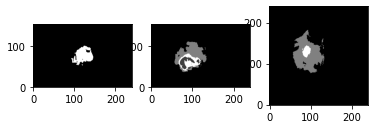

In [5]:
#displaying the image in all axes
slice_0 = test_image[120, :, :]
slice_1 = test_image[:, 120, :]
slice_2 = test_image[:, :, 78]
show_slices([slice_0, slice_1, slice_2])

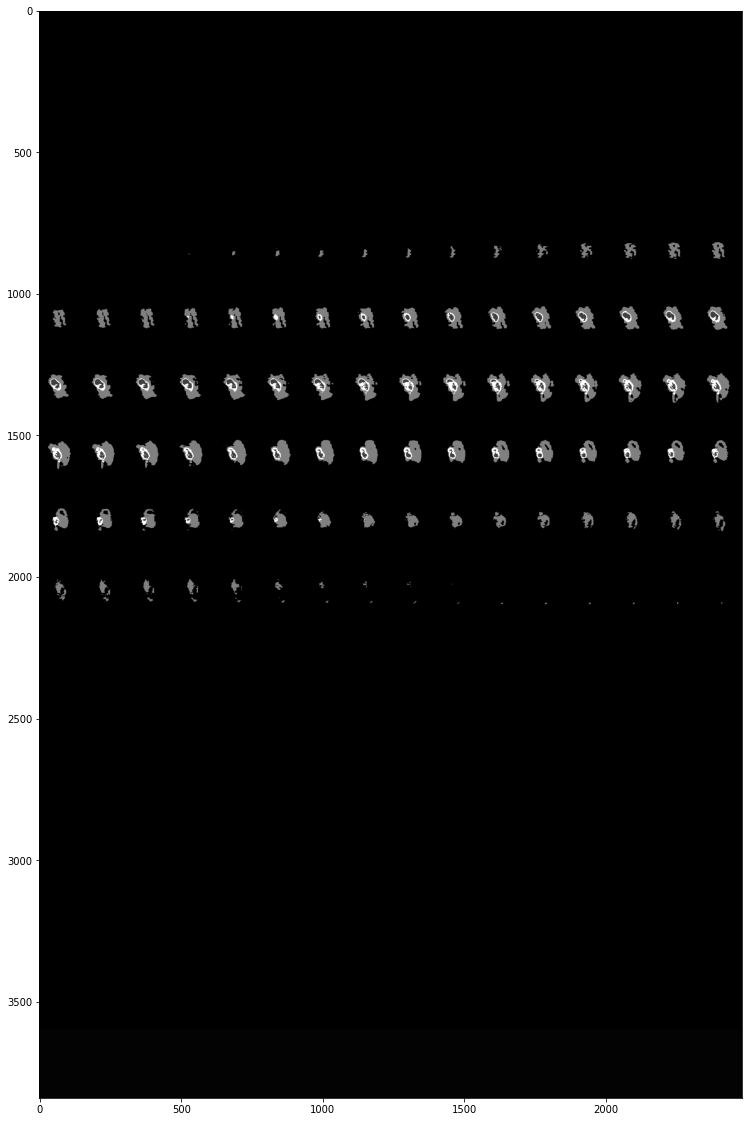

In [6]:
#displaying a montage of the image in x axis
fig, ax1 = plt.subplots(1, 1, figsize = (20, 20))
ax1.imshow(montage(test_image), cmap ='gray')

In [7]:
#creating a separate dataset segregated by modality
#import shutil,os
#dataset_dir_path = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
#for training_sample_folder in os.listdir(dataset_dir_path) :
#  if(not(training_sample_folder.endswith(".csv"))):
#    for filename in os.listdir(os.path.join(dataset_dir_path,training_sample_folder)) :
#      x = filename.split('_')
#      image_type = x[3]
#      dir_path = os.path.join(dataset_dir_path,training_sample_folder)
#      if(image_type == "flair.nii.gz"):
#        shutil.copy((os.path.join(dir_path, filename)) , '/content/separate_dataset/flair')
#      if(image_type == "seg.nii.gz"):
#        shutil.copy((os.path.join(dir_path, filename)) , '/content/separate_dataset/seg')
#      if(image_type == 't1ce.nii.gz'):
#        shutil.copy((os.path.join(dir_path, filename)) , '/content/separate_dataset/t1ce')
#      if(image_type == 't1.nii.gz'):
#        shutil.copy((os.path.join(dir_path, filename)) , '/content/separate_dataset/t1')
#      if(image_type == 't2.nii.gz'):
#        shutil.copy((os.path.join(dir_path, filename)) , '/content/separate_dataset/t2')


Check link [Manipulating Brain MRI](https://www.datacamp.com/community/tutorials/reconstructing-brain-images-deep-learning)

In [8]:
'''
#reading survival_info csv file and displaying data 

import csv

survival_info_path = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/survival_info.csv'

age_dict = {}
days_dict = {}

with open(survival_info_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
    line_count = 0
    a = 0
    b = 0
    c = 0
    max_days = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            max_days = max(max_days,int(days))
            if int(days) < 250:
                a += 1
            elif (int(days) >= 250 and int(days) <= 500):
                b += 1
            else:
                c += 1
            line_count+=1

    print(f'Processed {line_count} lines.')
    #age_m = np.zeros((1,1))
    print(a,b,c)
    print(max_days)
'''

'\n#reading survival_info csv file and displaying data \n\nimport csv\n\nsurvival_info_path = \'/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/survival_info.csv\'\n\nage_dict = {}\ndays_dict = {}\n\nwith open(survival_info_path, mode=\'r\') as csv_file:\n    csv_reader = csv.reader(csv_file,delimiter = \',\')\n    line_count = 0\n    a = 0\n    b = 0\n    c = 0\n    max_days = 0\n    for row in csv_reader:\n        if line_count == 0:\n            print(f\'Column names are {", ".join(row)}\')\n            line_count += 1\n        else:\n            print(row)\n            key = row[0]\n            age = row[1]\n            days = row[2]\n            age_dict[key] = float(age)\n            days_dict[key] = int(days)\n            max_days = max(max_days,int(days))\n            if int(days) < 250:\n                a += 1\n            elif (int(days) >= 250 and int(days) <= 500):\n                b += 1\n            else:\n                c += 1\n            line_cou

In [10]:
#Extracting features and storing in features.csv file

survival_info_path = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/survival_info.csv'
age_dict = {}
days_dict = {}
keys = []
line_count = 0

#reading survival_info.csv file and storing the given image id's in array, and age and survival days in dict
with open(survival_info_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
        else:
          keys.append(row[0])
          age = row[1]
          days = row[2]
          age_dict[row[0]] = float(age)
          days_dict[row[0]] = int(days)         

#print(keys)

#param file and intializing extractor
paramPath = os.path.join(os.getcwd(), "..", "Params.yaml")
#print ("Parameter file, absolute path:", os.path.abspath(paramPath))
settings = {'label': 2} #specifying the ROI
extractor = featureextractor.RadiomicsFeatureExtractor(additionalInfo=True, **settings)
count=0

#fetching flair and seg files and assigning to extractor

dataset_dir_path = '/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'

with open('/content/drive/My Drive/Colab Notebooks/MICCAI_BraTS2020_TrainingData/features.csv', 'w', newline='') as csvfile:
      writer_var = csv.writer(csvfile, delimiter=',')
      writer_var.writerow(['ID', 'Age', 'Survival_Days', 'original_shape_VoxelVolume', 'original_shape_SurfaceArea', 'original_shape_MajorAxisLength'])
      for id in keys:
        print(id)
        training_sample = os.path.join(dataset_dir_path,id) 
        for filename in os.listdir(training_sample):
          x = filename.split('_')
          image_type = x[3]
          if(image_type == "flair.nii.gz"):
            flair_file = filename
          if(image_type == "seg.nii.gz"):
            seg_file = filename
        # Store the file paths of testing image and label map into two variables
        imagePath = os.path.join(training_sample, flair_file)
        maskPath = os.path.join(training_sample, seg_file)

        #print("Extraction parameter:\n\t", extractor.settings)
        #print("Enabled filter:\n\t", extractor.enabledImagetypes)
        #print("Enabled feature:\n\t", extractor.enabledFeatures)


        #extract features
        result = extractor.execute(imagePath, maskPath)

        #store extracted features and other features in features.csv
        writer_var.writerow([id,age_dict[id],days_dict[id],result['original_shape_VoxelVolume'], result['original_shape_SurfaceArea'], result['original_shape_MajorAxisLength']])




BraTS20_Training_001


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_002


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_003


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_004


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_005


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_006


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_007


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_008


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_009


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_010


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_011


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_012


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_013


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_014


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_015


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_016


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_017


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_018


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_019


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_020


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_021


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_022


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_023


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_024


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_025


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_026


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_027


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_028


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_029


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_030


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_031


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_032


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_033


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_034


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_035


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_036


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_037


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_038


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_039


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_040


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_041


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_042


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_043


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_044


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_045


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_046


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_047


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_048


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_049


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_050


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_051


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_052


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_053


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_054


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_055


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_056


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_057


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_058


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_059


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_060


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_061


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_062


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_063


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_064


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_065


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_066


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_067


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_068


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_069


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_070


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_071


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_072


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_073


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_074


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_075


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_076


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_077


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_078


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_079


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_080


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_081


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_082


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_083


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_084


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_085


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_086


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_087


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_088


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_089


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_090


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_091


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_092


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_093


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_094


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_095


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_096


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_097


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_098


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_099


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_100


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_101


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_102


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_103


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_104


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_105


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_106


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_107


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_108


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_109


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_110


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_111


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_112


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_113


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_114


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_115


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_116


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_117


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_118


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_119


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_120


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_121


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_122


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_123


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_124


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_125


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_126


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_127


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_128


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_145


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_147


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_151


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_152


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_153


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_154


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_157


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_158


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_159


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_160


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_161


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_162


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_163


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_164


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_165


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_166


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_167


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_168


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_169


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_170


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_173


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_174


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_175


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_177


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_178


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_179


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_180


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_181


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_182


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_183


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_184


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_185


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_186


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_187


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_188


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_189


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_190


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_191


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_192


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_194


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_195


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_196


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_199


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_201


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_203


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_204


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_206


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_210


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_214


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_215


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_216


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_217


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_218


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_219


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_220


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_221


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_222


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_223


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_224


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_225


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_226


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_227


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_228


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_229


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_230


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_231


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_233


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_235


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_236


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_238


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_239


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_240


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_241


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_242


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_246


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_247


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_249


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_250


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_251


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_252


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_253


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_254


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_255


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_337


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_338


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_339


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_340


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_341


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_342


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_345


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_346


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_347


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_348


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_351


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_353


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_354


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_355


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_356


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_357


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_358


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_359


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_360


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_363


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_366


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_367


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_368


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


BraTS20_Training_369


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated
